# TP Noté : Robot Learning - Manipulation Robotique Robot So-Arm 101 – HuggingFace LeRobot 🤗🤖

Mineure Robotique - Décembre 2025

## Membres du groupe
- Alexis Le Trung
- Matéo Lelong
- Maxim Bocquillion
- Titouan Verhille

# Contexte et objectifs du TP

Le but de ce projet est la manipulation du robot So-Arm 101 et la mise en place d'une pipeline complète de Robot Learning par imitation.

<img src="./assets/robots.png" alt="robots" width="500">

# Liens utiles 
- [Dataset d'entraînement](https://huggingface.co/datasets/titouv/record-test)
- [Dataset de évaluation](https://huggingface.co/datasets/titouv/eval_record-test)
- [Politique d'entraînement](https://huggingface.co/titouv/policy/tree/main)

# Configuration et imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lerobot.datasets.lerobot_dataset import LeRobotDataset

/opt/homebrew/Caskroom/miniconda/base/envs/lerobot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Installation et calibration

La première étape de ce projet est **la calibration** les deux robots.

Voici les résultats obtenus après calibration sur les **positions minimales et maximales** des robots :
<img src="./assets/calibration.png" alt="robots" width="700">

# Chargement et analyse des données brutes

In [2]:
HF_USER = "titouv"
DATASET_NAME = "record-test"
SPLIT = "train"

NUM_JOINTS = 6        # exclude gripper
NOISE_STD = 0.02      # Gaussian noise level
TEMPORAL_SHIFT = 2    # number of timesteps

In [3]:
from lerobot.datasets.lerobot_dataset import LeRobotDataset

dataset = LeRobotDataset(f"{HF_USER}/{DATASET_NAME}")

print(f"Episodes: {dataset.num_episodes}, FPS: {dataset.fps}")

Episodes: 10, FPS: 30


# Nettoyage et augmentation des données

## Nettoyage

In [4]:
def compute_global_stats(dataset, num_joints, max_episodes=None):
    states_all = []
    actions_all = []

    n_eps = len(dataset)
    if max_episodes is not None:
        n_eps = min(n_eps, max_episodes)

    for i in range(n_eps):
        ep = dataset[i]
        states_all.append(ep["observation.state"])

        action = ep["action"]
        actions_all.append(action[:num_joints])

    states = np.concatenate(states_all, axis=0)
    actions = np.concatenate(actions_all, axis=0)

    return (
        states.mean(axis=0),
        states.std(axis=0) + 1e-8,
        actions.mean(axis=0),
        actions.std(axis=0) + 1e-8,
    )

    
def normalize(x, mean, std):
    return (x - mean) / std

In [5]:
print(dataset[0].keys())


dict_keys(['observation.images.wrist', 'action', 'observation.state', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index', 'task'])


objc[32262]: Class AVFFrameReceiver is implemented in both /opt/homebrew/Caskroom/miniconda/base/envs/lerobot/lib/python3.10/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x115f343a8) and /opt/homebrew/Caskroom/miniconda/base/envs/lerobot/lib/libavdevice.61.3.100.dylib (0x11f2187a0). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[32262]: Class AVFAudioReceiver is implemented in both /opt/homebrew/Caskroom/miniconda/base/envs/lerobot/lib/python3.10/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x115f343f8) and /opt/homebrew/Caskroom/miniconda/base/envs/lerobot/lib/libavdevice.61.3.100.dylib (0x11f2187f0). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.


In [6]:
state_mean, state_std, act_mean, act_std = compute_global_stats(
    dataset,
    num_joints=NUM_JOINTS,
)

print("State mean:", state_mean)
print("State std:", state_std)
print("Action mean:", act_mean)
print("Action std:", act_std)

State mean: 12.291936
State std: 24.23935
Action mean: 11.670998
Action std: 24.374456


In [7]:
# Correct way to extract episode data from LeRobotDataset
episode_idx = 0

# Get all frames for this episode
episode_frames = []
for i in range(len(dataset.hf_dataset)):
    frame = dataset[i]
    if frame['episode_index'] == episode_idx:
        episode_frames.append(frame)

# Now extract states and actions from the episode
states = []
actions = []

for frame in episode_frames:
    states.append(frame['observation.state'].numpy())
    action = frame['action'].numpy()
    actions.append(action[:NUM_JOINTS])  # Only first 6 joints

# Convert to numpy arrays
import numpy as np
states = np.array(states)
actions = np.array(actions)

# Normalize
states_n = normalize(states, state_mean, state_std)
actions_n = normalize(actions, act_mean, act_std)

print(f"Episode {episode_idx}: {len(episode_frames)} frames")
print(f"States shape: {states.shape}")
print(f"Actions shape: {actions.shape}")


Episode 0: 581 frames
States shape: (581, 6)
Actions shape: (581, 6)


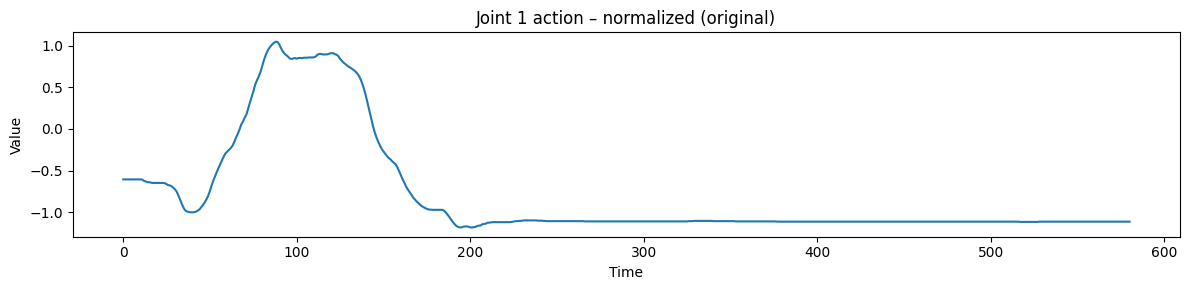

In [8]:
plt.figure(figsize=(12, 3))

plt.plot(actions_n[:, 0])

plt.title("Joint 1 action – normalized (original)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

## Augmentations de données

Nous allons maintenant appliquer les augmentations de données suivante :
- **Le Bruit gaussien** (Gaussian Noise) : 
    
    Cette méthode ajoute de légères variations aléatoires aux signaux pour simuler les imperfections naturelles des capteurs du robot. Elle empêche le modèle de mémoriser des valeurs exactes, le rendant plus robuste face aux imprécisions du monde réel.
- **Le Décalage temporel** (Temporal Shift) :
    
    Cette technique décale les observations par rapport aux actions pour simuler ou corriger les délais de réaction entre la vision et le mouvement. Elle apprend au robot à anticiper la dynamique du système et à rester stable même si les données ne sont pas parfaitement synchronisées.




In [9]:
def add_gaussian_noise(x, sigma):
    return x + np.random.normal(0.0, sigma, size=x.shape)


def temporal_shift(states, actions, shift):
    assert shift > 0
    return states[shift:], actions[:-shift]

In [10]:
# --- Augmentation 1: Gaussian noise ---
states_noise = add_gaussian_noise(states_n, NOISE_STD)
actions_noise = add_gaussian_noise(actions_n, NOISE_STD)

# --- Augmentation 2: Temporal shift ---
states_shift, actions_shift = temporal_shift(
    states_n, actions_n, TEMPORAL_SHIFT
)

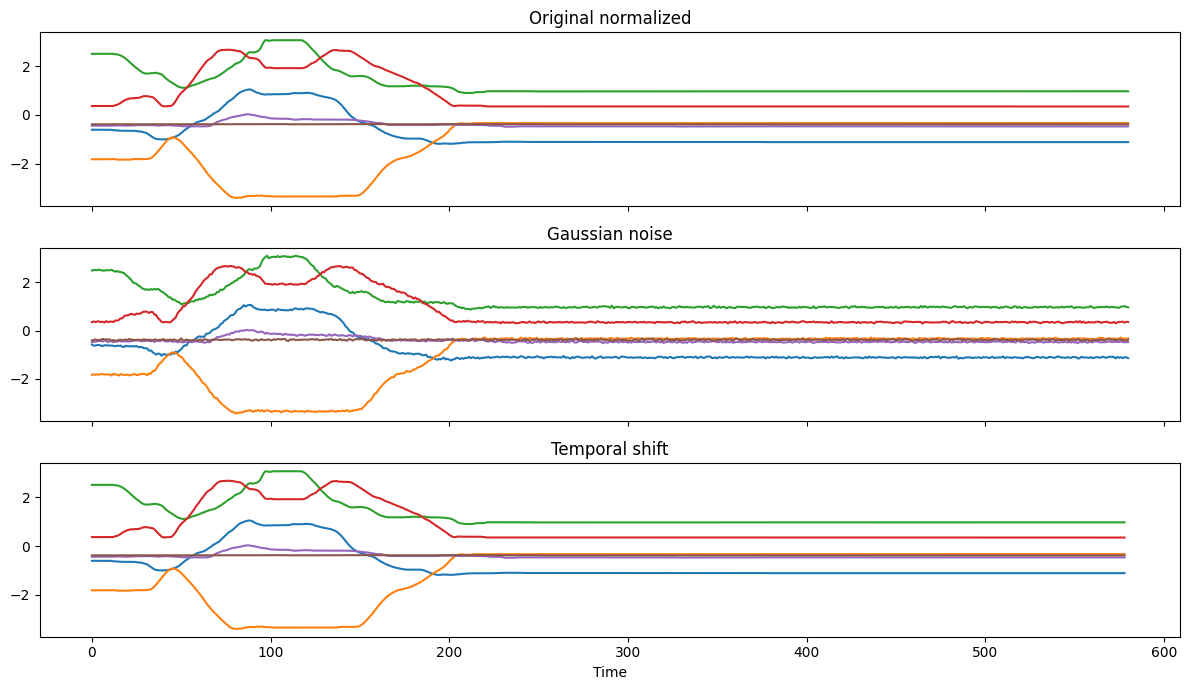

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

axes[0].plot(actions_n[:, ])
axes[0].set_title("Original normalized")

axes[1].plot(actions_noise[:, ])
axes[1].set_title("Gaussian noise")

axes[2].plot(actions_shift[:, ])
axes[2].set_title("Temporal shift")

plt.xlabel("Time")
plt.tight_layout()
plt.show()

__Observation des résultats :__

Les graphiques ci-dessus confirment la **bonne application des augmentations de données**. 

On distingue nettement **l'effet du bruit gaussien** : bien que d'amplitude modérée, il est clairement perceptible à travers les micro-oscillations qui "cassent" l'aspect artificiellement lisse des courbes originales. 

Le **décalage temporel** est également effectif ; il conserve parfaitement la topologie globale de la trajectoire tout en modifiant l'alignement temporel, ce qui est essentiel pour la robustesse face à la latence.

# Création et validation du dataset LeRobot

Nous avons pu enregistré un dataset d'entrainement avec un mouvement simple : le robot doit se déplacer sur sa droite afin de toucher un paquet de mouchoirs. 

Voici un extrait du dataset obtenu :

![datasets](assets/validation.gif)

Le dataset a été créée à l'aide de la commande :

```sh

lerobot-record \
          --robot.type=so101_follower \
          --robot.port=/dev/tty.usbmodem5A7C1216181 \
          --robot.id=follower_arm \
          --robot.cameras="{ front: {type: opencv, index_or_path: 1, width: 640, height: 480, fps: 30}, wrist: {type: opencv, index_or_path: 0, width: 640, hei
ght: 480, fps: 30}}" \
          --teleop.type=so101_leader \
          --teleop.port=/dev/tty.usbmodem5A7C1163501 \
          --teleop.id=leader_arm \
          --display_data=false \
          --dataset.reset_time_s=5 \
          --dataset.episode_time_s=20 \
          --dataset.num_episodes=10 \
          --dataset.repo_id=titouv/record-test2 \
          --dataset.single_task="Reach the pen" \
          --dataset.push_to_hub=true
```


![datasets](assets/training.png)

Analyse : L’entraînement a été réalisé sur un premier ordinateur dôté d'un GPU.
Nous avons pu entraîner le modèle sur notre dataset pendant 1 500 étapes. La loss a rapidement diminué, passant de 6,757 à 0,737.


# Entraînement de la politique

La commande pour entrainer la politique du robot est :

```sh
lerobot-train   --dataset.repo_id=titouv/record-test   --policy.type=act   --output_dir=outputs/train/act_so101_test   --job_name=act_so101_test   --policy.device=cuda   --wandb.enable=false   --policy.repo_id=titouv/act_so101_test --steps=3000

```

Nous avons du envoyer les poids que nous avons entrainé d'un ordinateur pour le récupérer sur un autre car l'execution sur le premier ne marchait pas. Cette commande nous a permis de les envoyer sur HuggingFace
```
huggingface-cli upload titouv/policy   outputs/train/act_so101_test/checkpoints/last/pretrained_model/
```

# Tests du modèle et résultats

![img](assets/evaluation.gif)

Malgré un entraînement limité à seulement 1 000 étapes, le modèle parvient à détecter le paquet de mouchoirs lorsqu’on le lui présente. Cette performance reste limitée par le fait de n’avoir qu’une seule caméra. Cependant, une fois que le robot sait où se trouve le paquet, il reproduit presque parfaitement le mouvement appris lors de l’entraînement.


L'évaluation a été effectué à l'aide de la commande suivante :

```lerobot-record  \
  --robot.type=so101_follower \
  --robot.port=/dev/tty.usbmodem5A7C1216181 \
   --robot.cameras="{ wrist: {type: opencv, index_or_path: 0, width: 640, height: 480, fps: 30}}" \
  --robot.id=follower_arm \
  --display_data=false \
  --dataset.single_task="Put lego brick into the transparent box" \
  --dataset.repo_id=titouv/eval_record-test \
  --policy.path=titouv/policy
```

# Analyse critique et conclusions

## Problèmes rencontrées
Nous avons rencontré plusieurs problèmes techniques lors de nos expériences :

- **Caméra instable :** la caméra s’éteint régulièrement, ce qui entraîne des interruptions dans l’acquisition des données et complique l’entraînement du modèle.
- **Problèmes de calibration :** la caméra nécessite un recalibrage fréquent, ce qui peut introduire des erreurs de positionnement et affecter la précision de la détection.

- **Changement de tâche :** lorsque le robot doit passer d’une tâche à une autre, le modèle peine à s’adapter rapidement, ce qui impacte la fluidité et la performance des mouvements.

- **Limitations matérielles :** un des PC ne peut pas enregistrer les données, tandis que l’autre prend un temps considérable pour entraîner le modèle en l’absence de GPU, ralentissant significativement le processus global.

## Limitations
- **Nombre de caméras limité :** nous n’utilisons qu’une seule caméra au lieu de deux, ce qui réduit la perception en profondeur et peut affecter la précision de la détection et du positionnement.

- **Entraînement incomplet :** le modèle n’a pas été entraîné sur un nombre suffisant d’étapes, ce qui limite sa capacité à généraliser et à reproduire parfaitement les mouvements.

- **Jeu de données insuffisant :** le dataset utilisé reste restreint, ce qui limite la diversité des situations apprises par le modèle.

- **Manque d’augmentation de données :** l’absence de techniques d’augmentation réduit la robustesse du modèle face à des variations imprévues dans l’environnement ou les objets à manipuler.